In [157]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [158]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [159]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [160]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [161]:
dims = 2

W2 = Vt.T[:, :dims]
X2D = X_centered.dot(W2)
X2D_using_svd = X2D

In [162]:
from sklearn.decomposition import PCA
pca = PCA(n_components = dims)
X2D = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [163]:
np.allclose(X2D, -X2D_using_svd)

True

In [164]:
X3D_inv = pca.inverse_transform(X2D)
np.allclose(X3D_inv, X)
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

False

0.010170337792848549

In [165]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [166]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [167]:
len(X_test)
len(X_train)

17500

52500

In [168]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

PCA()

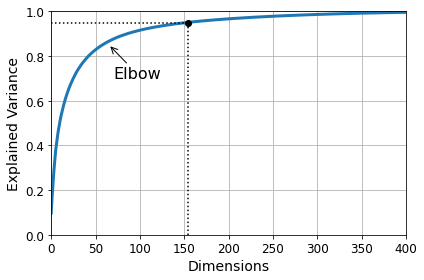

In [169]:
from IPython.utils import io

with io.capture_output() as captured:
    plt.figure(figsize=(6,4))
    plt.plot(cumsum, linewidth=3)
    plt.axis([0, 400, 0, 1])
    plt.xlabel("Dimensions")
    plt.ylabel("Explained Variance")
    plt.plot([d, d], [0, 0.95], "k:")
    plt.plot([0, d], [0.95, 0.95], "k:")
    plt.plot(d, 0.95, "ko")
    plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
                arrowprops=dict(arrowstyle="->"), fontsize=16)
    plt.grid(True)
    save_fig("explained_variance_plot")
plt.show()

Better way to perserve 95% of the variance would be to just say hey preserve me 95%

In [170]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [171]:
pca = PCA(n_components = 50)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [172]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

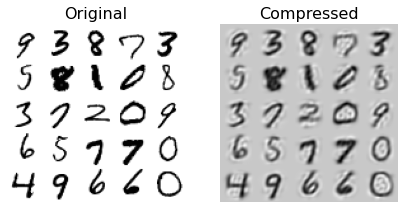

In [173]:
with io.capture_output() as captured:
    plt.figure(figsize=(7, 4))
    plt.subplot(121)
    plot_digits(X_train[::2100])
    plt.title("Original", fontsize=16)
    plt.subplot(122)
    plot_digits(X_recovered[::2100])
    plt.title("Compressed", fontsize=16)

In [174]:
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)
np.sum(rnd_pca.explained_variance_ratio_)

0.9500342385100192

In [175]:
rnd_pca = PCA(n_components=154, svd_solver="full")
X_reduced = rnd_pca.fit_transform(X_train)
np.sum(rnd_pca.explained_variance_ratio_)

0.9503684424557439

In [176]:
X_test_pca = rnd_pca.transform(X_test)
X_test_pca_recovered = rnd_pca.inverse_transform(X_test_pca)

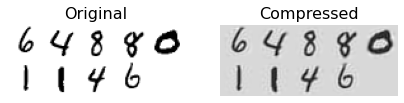

In [177]:
with io.capture_output() as captured:
    plt.figure(figsize=(7, 4))
    plt.subplot(121)
    plot_digits(X_test[::2100])
    plt.title("Original", fontsize=16)
    plt.subplot(122)
    plot_digits(X_test_pca_recovered[::2100])
    plt.title("Compressed", fontsize=16)

In [178]:
from sklearn.decomposition import IncrementalPCA
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
with io.capture_output() as captured:
    for X_batch in np.array_split(X_train, n_batches):
        inc_pca.partial_fit(X_batch)
X_reduced = inc_pca.transform(X_train)

In [179]:
from sklearn.datasets import make_blobs

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

<Figure size 576x288 with 0 Axes>

Saving figure blobs_plot


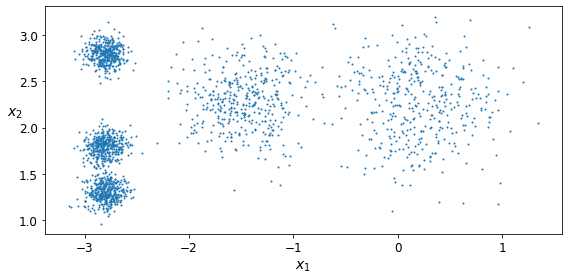

In [180]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

In [181]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

In [182]:
y_pred

array([0, 4, 1, ..., 2, 1, 4])

In [183]:
y_pred is kmeans.labels_

True

In [184]:
kmeans.cluster_centers_

array([[-2.80037642,  1.30082566],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80389616,  1.80117999]])

In [185]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)
kmeans.transform(X_new)

array([1, 1, 2, 2])

array([[2.88633901, 0.32995317, 2.9042344 , 1.49439034, 2.81093633],
       [5.84236351, 2.80290755, 5.84739223, 4.4759332 , 5.80730058],
       [1.71086031, 3.29399768, 0.29040966, 1.69136631, 1.21475352],
       [1.21567622, 3.21806371, 0.36159148, 1.54808703, 0.72581411]])

In [186]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)

In [187]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

<Figure size 576x252 with 0 Axes>

Text(0.5, 0, '$k$')

Text(0, 0.5, 'Inertia')

Text(0.55, 0.55, 'Elbow')

(1.0, 8.5, 0.0, 1300.0)

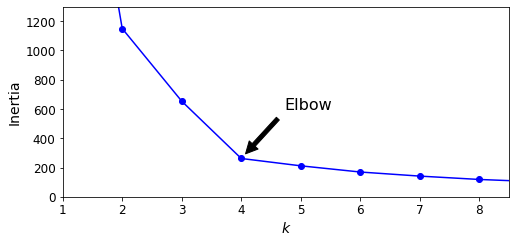

In [188]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
#ave_fig("inertia_vs_k_plot")
plt.show()

In [190]:
from sklearn.metrics import silhouette_score
kmeans.fit(X)
silhouette_score(X, kmeans.labels_)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1)

0.655517642572828

In [195]:
from matplotlib.image import imread # or `from imageio import imread`
image = imread(os.path.join("images","ladybug.png"))
image.shape

(1195, 2125, 3)

In [197]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Original image')

(-0.5, 2124.5, 1194.5, -0.5)

Text(0.5, 1.0, '10 colors')

(-0.5, 2124.5, 1194.5, -0.5)

Text(0.5, 1.0, '8 colors')

(-0.5, 2124.5, 1194.5, -0.5)

Text(0.5, 1.0, '6 colors')

(-0.5, 2124.5, 1194.5, -0.5)

Text(0.5, 1.0, '4 colors')

(-0.5, 2124.5, 1194.5, -0.5)

Text(0.5, 1.0, '2 colors')

(-0.5, 2124.5, 1194.5, -0.5)

Saving figure image_segmentation_diagram


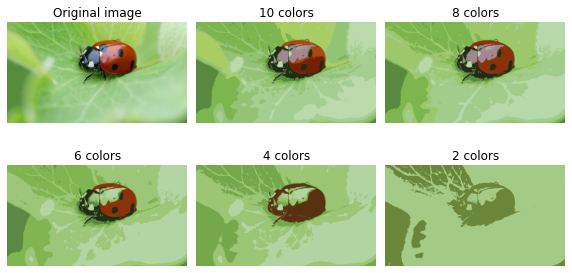

In [198]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

In [199]:
from sklearn.datasets import load_digits
X_digits, y_digits = load_digits(return_X_y=True)

In [200]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

In [218]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [219]:
log_reg.score(X_test, y_test)

0.9533333333333334

<Figure size 288x144 with 0 Axes>

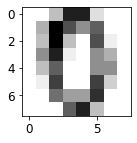

In [220]:
some_digit = X_train[3]

some_digit_image = some_digit.reshape(8, 8)
plt.figure(figsize=(4, 2)) 
plt.imshow(some_digit_image, cmap=mpl.cm.binary)

In [221]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50)),
    ("log_reg", LogisticRegression()),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                ('log_reg', LogisticRegression())])

In [222]:
pipeline.score(X_test, y_test)

0.9622222222222222

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

In [ ]:
grid_clf.best_params_
grid_clf.score(X_test, y_test)